Steps:
Feature and label preparation

Train/test split

Training with XGBoost

Predictions

Classification report (precision, recall, f1-score per class)

In [1]:
# Installing dependencies

%pip install -r ../requirements.txt


  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
print("Preparing features and labels...")
import cudf
import cupy as cp
from cuml.preprocessing import LabelEncoder

# Reading CSV file with cuDF (GPU)
df = cudf.read_csv('../data/processed_file_cleaned.csv')

# Checking columns to drop (since cuDF doesn't support errors='ignore')
columns_to_drop = [col for col in ['Label', 'mapped_label'] if col in df.columns]
X = df.drop(columns=columns_to_drop)

# Extracting target variable
y = df['mapped_label']

# Label encoding (on GPU)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Features and labels prepared successfully!")

Preparing features and labels...
Features and labels prepared successfully!


In [3]:
print("Splitting the dataset into training and testing sets...")

from cuml.model_selection import train_test_split

# cuDF DataFrame + cupy/cudf Series → tout sur le GPU
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded  # fonctionne avec cuDF Series
)

print("Dataset split successfully!")


Splitting the dataset into training and testing sets...
Dataset split successfully!


In [4]:
# WIth weight cap? FIrst 20.0

print("Calculating class weights for Bot class balancing...")
import cupy as cp
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Identify Bot class
bot_class_index = None
class_names = le.classes_.to_pandas().tolist()
for i, class_name in enumerate(class_names):
    if 'Bot' in class_name:
        bot_class_index = i
        break

print(f"Bot class found at index: {bot_class_index}")
print(f"Class names: {class_names}")

# Count samples per class in training set
y_train_numpy = y_train.to_pandas().values
unique, counts = np.unique(y_train_numpy, return_counts=True)

print("Distribution in training set:")
for i, count in zip(unique, counts):
    print(f"  {class_names[i]}: {count}")

# Calculate balanced class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_numpy),
    y=y_train_numpy
)

# Convert to dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"\nClass weights (balanced - original):")
for i, weight in class_weight_dict.items():
    print(f"  {class_names[i]}: {weight:.3f}")

# Adjust Bot weight to improve precision
bot_weight_cap = 20.0  # Teste 10, 20, 50
print(f"\nAdjusting Bot weight from {class_weight_dict[bot_class_index]:.1f} to {min(class_weight_dict[bot_class_index], bot_weight_cap):.1f}")
class_weight_dict[bot_class_index] = min(class_weight_dict[bot_class_index], bot_weight_cap)

print(f"\nFinal class weights:")
for i, weight in class_weight_dict.items():
    print(f"  {class_names[i]}: {weight:.3f}")

# Keep data on GPU
X_train_cp = X_train.to_cupy()
y_train_cp = y_train.to_cupy()

print("\nData ready for GPU training with balanced classes!")

Calculating class weights for Bot class balancing...
Bot class found at index: 1
Class names: ['BENIGN', 'Bot', 'DOS/DDOS', 'Patator', 'PortScan', 'WebAttack']
Distribution in training set:
  BENIGN: 1817056
  Bot: 1565
  DOS/DDOS: 303798
  Patator: 11066
  PortScan: 127043
  WebAttack: 1744

Class weights (balanced - original):
  BENIGN: 0.208
  Bot: 240.924
  DOS/DDOS: 1.241
  Patator: 34.072
  PortScan: 2.968
  WebAttack: 216.196

Adjusting Bot weight from 240.9 to 20.0

Final class weights:
  BENIGN: 0.208
  Bot: 20.000
  DOS/DDOS: 1.241
  Patator: 34.072
  PortScan: 2.968
  WebAttack: 216.196

Data ready for GPU training with balanced classes!


In [5]:
print("Training the XGBoost model with class balancing...")

import xgboost as xgb

sample_weights = np.array([class_weight_dict[label] for label in y_train_numpy])

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',
    device='cuda',
    random_state=42
)

# Entraînement avec poids sur GPU
model.fit(
    X_train_cp, 
    y_train_cp,
    sample_weight=cp.asarray(sample_weights)  # Poids sur GPU
)

print("Model trained successfully!")

Training the XGBoost model with class balancing...
Model trained successfully!


In [6]:
#predictions
print("Making predictions on the test set...")
y_pred = model.predict(X_test)
print("Predictions made successfully!")

Making predictions on the test set...
Predictions made successfully!


/opt/conda/lib/python3.11/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


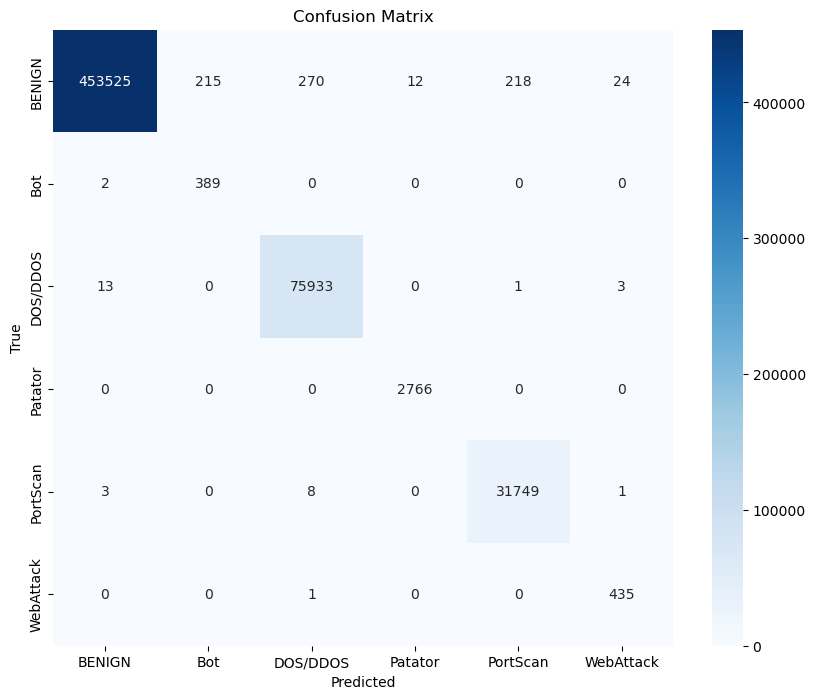


Classification Report:

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    454264
         Bot       0.64      0.99      0.78       391
    DOS/DDOS       1.00      1.00      1.00     75950
     Patator       1.00      1.00      1.00      2766
    PortScan       0.99      1.00      1.00     31761
   WebAttack       0.94      1.00      0.97       436

    accuracy                           1.00    565568
   macro avg       0.93      1.00      0.96    565568
weighted avg       1.00      1.00      1.00    565568


Classification Report DataFrame:

              precision    recall  f1-score        support
BENIGN         0.999960  0.998373  0.999166  454264.000000
Bot            0.644040  0.994885  0.781910     391.000000
DOS/DDOS       0.996339  0.999776  0.998055   75950.000000
Patator        0.995680  1.000000  0.997835    2766.000000
PortScan       0.993149  0.999622  0.996375   31761.000000
WebAttack      0.939525  0.997706  0.967742

In [7]:
# Display the results

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import pandas as pd

# GPU -> CPU conversion
y_test_cpu = y_test.to_numpy()
y_pred_cpu = y_pred

# Confusion matrix
cm = confusion_matrix(y_test_cpu, y_pred_cpu)

# Fix: Convert cuDF StringColumn to Python list
class_names = le.classes_.to_pandas().tolist()

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report (text)
print("\nClassification Report:\n")
print(classification_report(y_test_cpu, y_pred_cpu, target_names=class_names))

# Report as pandas DataFrame (easier to manipulate)
report_dict = classification_report(y_test_cpu, y_pred_cpu, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\nClassification Report DataFrame:\n")
print(report_df)

# Global metrics (macro and micro)
f1_macro = f1_score(y_test_cpu, y_pred_cpu, average='macro')
f1_micro = f1_score(y_test_cpu, y_pred_cpu, average='micro')
accuracy = accuracy_score(y_test_cpu, y_pred_cpu)
precision_macro = precision_score(y_test_cpu, y_pred_cpu, average='macro')
recall_macro = recall_score(y_test_cpu, y_pred_cpu, average='macro')

print(f"\nGlobal Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"F1-score (micro): {f1_micro:.4f}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")